### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [4]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, verbose=0):
    n_class = config.dataset.n_class
    if config.model.pretrained:
        model = torch.hub.load(
            repo_or_dir=config.model.repo,
            model=config.model.pretrained_model,
            pretrained=False,
        )
        model.head = nn.Linear(model.head.in_features, n_class)
    else:
        model = ViT(
            image_size=config.model.img_size,
            patch_size=config.model.patch_size,
            num_classes=n_class,
            dim=config.model.dim_head,
            depth=config.model.depth,
            heads=config.model.n_heads,
            mlp_dim=config.model.dim_mlp,
            dropout=config.model.dropout,
            emb_dropout=config.model.emb_dropout,
            visualize=True,
        )

    model = model.to(device=device)
    if verbose:
        print(model)

    checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

    state_dict = checkpoint['model_state_dict']
    trimmed_keys = []
    for key in state_dict.keys():
        # remove prefix 'module.' for each key (in case of DataParallel)
        trimmed_keys.append(key[7:])
    trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

    model.load_state_dict(trimmed_state_dict)
    return model

In [6]:
from torchvision.datasets import CIFAR10, SVHN
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

id_dataset = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
id_test_dataloader = DataLoader(
    dataset=id_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
id_dataset_name = 'cifar10'

ood_dataset = SVHN(
    root=dataset_root, 
    split='test',
    download=False, 
    transform=transform_test
)
ood_test_dataloader = DataLoader(
    dataset=ood_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
ood_dataset_name = 'svhn'

print(id_dataset.class_to_idx)
print(set(ood_dataset.labels))

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Utility

In [7]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 1234

### Visualize features

In [8]:
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

model = initialize_vit_model(config)
# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


In [38]:
# gather penultimate features
from ood_with_vit.utils import compute_penultimate_features

set_seed(seed)
num_samples = 10
num_class = 10

print('processing in-distribution samples...')
X_in, y_in = [], []
in_img_paths = []
cls_indices = random.sample(range(len(id_dataset.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(id_dataset.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = id_dataset[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_in.append(penultimate_features.squeeze().numpy())
        y_in.append((cls_idx, id_dataset.classes[cls_idx]))
        img_path = f'./assets/{id_dataset_name}/test/{i:05d}.jpg'
        # img_path = f'/assets/{id_dataset_name}/test/{i:05d}.jpg'
        in_img_paths.append(img_path)
        
print('processing out-of-distribution samples...')
X_out, y_out = [], []
out_img_paths = []
cls_indices = random.sample(range(len(set(ood_dataset.labels))), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(ood_dataset.labels) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = ood_dataset[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_out.append(penultimate_features.squeeze().numpy())
        y_out.append(str(cls_idx))
        img_path = f'./assets/{ood_dataset_name}/test/{i:05d}.jpg'
        # img_path = f'/assets/{ood_dataset_name}/test/{i:05d}.jpg'
        out_img_paths.append(img_path)

processing in-distribution samples...


100%|██████████| 10/10 [00:00<00:00, 105.93it/s]


processing out-of-distribution samples...


100%|██████████| 10/10 [00:00<00:00, 106.30it/s]


#### Feature visualization by T-SNE

In [45]:
from ipywidgets import HTML, VBox

def interactive_plot(partitioned_info, fig, img_width=240, event="click") :
    """
    Make a plot react on hover or click of a data point and update a HTML preview below it.    
    """
    html = HTML("")
    fig = go.FigureWidget(data=fig.data, layout=fig.layout)

    if event == "hover" :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="{img_width}"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_hover(update)
    else :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="{img_width}"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_click(update)

    return VBox([fig, html])

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_in)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
df_embed = df_embed.assign(img=in_img_paths)

partitioned_info, processed_labels = [], []
for label in y_in:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR10 finetuned ViT CIFAR100 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar10/test/00198.jpg'],
        …

In [47]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_out)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
df_embed = df_embed.assign(img=out_img_paths)

partitioned_info, processed_labels = [], []
for label in y_out:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())

fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR10 finetuned ViT SVHN T-SNE',
)
interactive_plot(partitioned_info, fig, 64, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/svhn/test/19935.jpg'],
           …

In [16]:
X_all = X_in + X_out
y_all = y_in + y_out
img_all = in_img_paths + out_img_paths
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_all)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_all)
df_embed = df_embed.assign(img=img_all)

partitioned_info, processed_labels = [], []
for label in y_all:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10, SVHN T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar10/test/00198.jpg'],
        …

#### Feature visualization by PCA

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(X_in)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
df_embed = df_embed.assign(img=in_img_paths)

partitioned_info, processed_labels = [], []
for label in y_in:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR10 finetuned ViT CIFAR10 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'hovertemplate': "class=(7, 'horse')<br>x=%{x}<br>y=%{y}<extra></e…

In [15]:
pca = PCA()
components = pca.fit_transform(X_out)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
df_embed = df_embed.assign(img=out_img_paths)

partitioned_info, processed_labels = [], []
for label in y_out:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained, CIFAR10 finetuned ViT CIFAR100 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'hovertemplate': 'class=7<br>x=%{x}<br>y=%{y}<extra></extra>',
   …

In [39]:
X_all = X_in + X_out
y_all = y_in + y_out
img_all = in_img_paths + out_img_paths
pca = PCA()
components = pca.fit_transform(X_all)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_all)
df_embed = df_embed.assign(img=img_all)

partitioned_info, processed_labels = [], []
for label in y_all:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10, SVHN PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar10/test/00198.jpg'],
        …

### OOD detection baselines

In [18]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

#### OOD detection by MSP (Maximum over Softmax Probability)

In [25]:
from ood_with_vit.metrics.msp import MSP

model = initialize_vit_model(config)
msp = MSP(config, model)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


In [26]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=msp,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


processing out-of-distribution samples...


100%|██████████| 261/261 [00:14<00:00, 18.56it/s]


id mean score: -0.9825615
ood mean score: -0.5879053


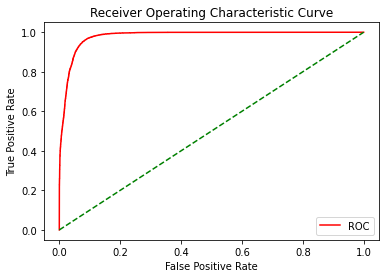

MSP AUROC score: 0.97953201


In [27]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('MSP AUROC score:', auroc_score)

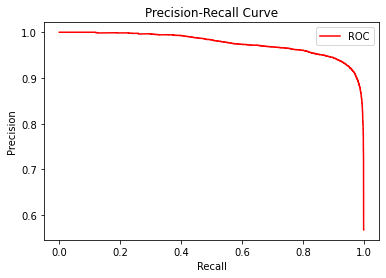

MSP AUPR score: 0.9757307094062874


In [28]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('MSP AUPR score:', aupr_score)

In [29]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('MSP fpr95 score:', fpr95)

MSP fpr95 score: 0.0756


### OOD detection by Mahalanobis

In [19]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, id_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.97it/s]


covairance norms: [58.213383, 111.35267, 49.149143, 44.527348, 99.387886, 59.178444, 104.78499, 80.21675, 87.104904, 63.132908]
covariance norm: 29.670227021092874


In [20]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


processing out-of-distribution samples...


100%|██████████| 261/261 [00:13<00:00, 18.72it/s]


id mean score: 215.34715 id variance: 21136.686
ood mean score: 693.95 ood variance: 44660.0


In [21]:
mahalanobis.compute_dataset_ood_score(id_test_dataloader)
classes = set(mahalanobis.closest_classes)
for c in classes:
    tmd = np.array(mahalanobis.total_mahalanobis_distances)
    cc = np.array(mahalanobis.closest_classes)
    c_tmd = tmd[list(np.where(cc == c)[0])]
    n_samples = mahalanobis.closest_classes.count(c)
    print(f'{c}, {cifar10.classes[c]}: {n_samples}, mean: {c_tmd.mean()}, var: {c_tmd.var()}')

mahalanobis.compute_dataset_ood_score(ood_test_dataloader)
classes = set(mahalanobis.closest_classes)
for c in classes:
    tmd = np.array(mahalanobis.total_mahalanobis_distances)
    cc = np.array(mahalanobis.closest_classes)
    c_tmd = tmd[list(np.where(cc == c)[0])]
    n_samples = mahalanobis.closest_classes.count(c)
    print(f'{c}, {cifar10.classes[c]}: {n_samples}, mean: {c_tmd.mean()}, var: {c_tmd.var()}')

100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


0, airplane: 1018, mean: 220.49879455566406, var: 23541.91015625
1, automobile: 964, mean: 195.30661010742188, var: 18286.0078125
2, bird: 1058, mean: 243.42190551757812, var: 30870.400390625
3, cat: 1026, mean: 248.9990234375, var: 29320.724609375
4, deer: 962, mean: 197.35235595703125, var: 13548.0478515625
5, dog: 1033, mean: 217.2900848388672, var: 16825.470703125
6, frog: 962, mean: 196.2056121826172, var: 19143.857421875
7, horse: 964, mean: 204.74002075195312, var: 18380.091796875
8, ship: 982, mean: 206.94052124023438, var: 18990.318359375
9, truck: 1031, mean: 217.32928466796875, var: 18014.09375


100%|██████████| 261/261 [00:13<00:00, 18.97it/s]


0, airplane: 1880, mean: 698.2384033203125, var: 33407.17578125
2, bird: 5769, mean: 660.5449829101562, var: 30104.4140625
3, cat: 16120, mean: 702.5452880859375, var: 47090.9609375
4, deer: 1, mean: 888.8529663085938, var: 0.0
5, dog: 894, mean: 534.7012329101562, var: 22808.62890625
6, frog: 80, mean: 707.6121215820312, var: 19461.208984375
7, horse: 3, mean: 621.4541625976562, var: 12089.70703125
8, ship: 17, mean: 639.4715576171875, var: 41562.0859375
9, truck: 1268, mean: 861.5384521484375, var: 52534.41015625


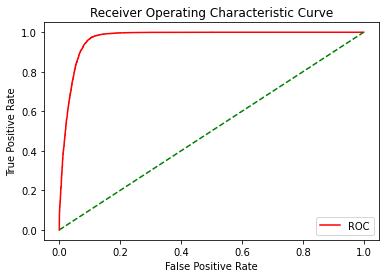

Mahalanobis AUROC score: 0.97032881


In [22]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

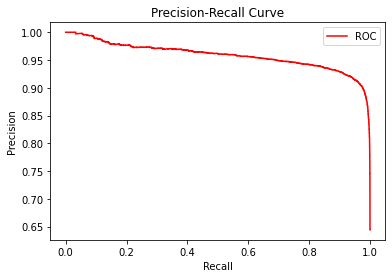

Mahalanobis AUPR score: 0.9583349634019925


In [23]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [24]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.0894


### OOD detection by SML (Standardized Max Logits)

In [30]:
from ood_with_vit.metrics.sml import SML

model = initialize_vit_model(config)
sml = SML(config, model, id_train_dataloader)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


In [31]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=sml,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


processing out-of-distribution samples...


100%|██████████| 261/261 [00:13<00:00, 19.55it/s]

id mean score: 0.1767480533869523 id variance: 1.4942061282549084
ood mean score: 5.2902633455482615 ood variance: 1.8708931763079546


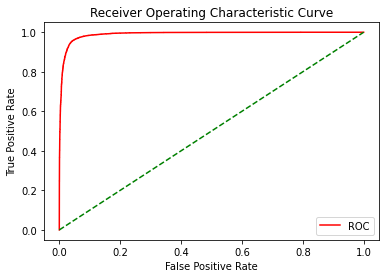

SML AUROC score: 0.9900661350000001


In [35]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('SML AUROC score:', auroc_score)

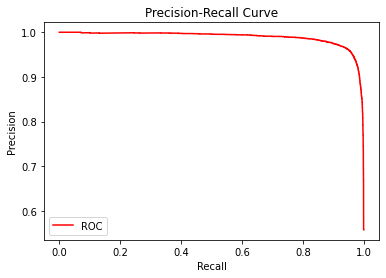

SML AUPR score: 0.9890504516877849


In [36]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('SML AUPR score:', aupr_score)

In [37]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('SML fpr95 score:', fpr95)

SML fpr95 score: 0.0384
